<a href="https://colab.research.google.com/github/hammad-m/SERP-Entity-Content-NLP-and-Keyword-Analysis/blob/main/SERP_Content_Entity%2C_Keyword_and_NLP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bs4
!pip install requests
!pip install fake_useragent
!pip install google

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=3737d8546108d676b4e618aa2adf7d018df96433ff8a0e2186ac4585afd02cb7
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
Successfully built fake-useragent


In [ ]:
import googlesearch
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
from copy import deepcopy
import time
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag, pos_tag_sents
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
import numpy as np
from lxml.html import fromstring
from fake_useragent import UserAgent
ua=UserAgent()
from googlesearch import search
import string
import en_core_web_sm
from collections import Counter
import itertools as it
import networkx as nx
from urllib.parse import urlparse
from nltk.stem import WordNetLemmatizer
wn = nltk.WordNetLemmatizer()
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('tagsets')
from urllib.parse import urlparse, urlsplit

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Error occurred during loading data. Trying to use cache server https://fake-useragent.herokuapp.com/browsers/0.1.11
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 154, in load
    for item in get_browsers(verify_ssl=verify_ssl):
  File "/usr/local/lib/python3.7/dist-packages/fake_useragent/utils.py", line 99, in get_browsers
    html = html.split('<table class="w3-table-all notranslate">')[1]
IndexError: list index out of range


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


In [ ]:
#fetching links from search results


################

query = 'seo'

number_of_links=50

###############

links=[]


for j in search(query, num=number_of_links, stop=number_of_links, pause=1):
  links.append(j)

print(links)

['https://moz.com/beginners-guide-to-seo', 'https://moz.com/beginners-guide-to-seo/why-search-engine-marketing-is-necessary', 'https://moz.com/beginners-guide-to-seo/on-page-seo', 'https://moz.com/beginners-guide-to-seo/technical-seo', 'https://moz.com/beginners-guide-to-seo/seo-glossary', 'https://en.wikipedia.org/wiki/Search_engine_optimization', 'https://en.wikipedia.org/wiki/Search_engine_optimization#History', 'https://en.wikipedia.org/wiki/Search_engine_optimization#Methods', 'https://en.wikipedia.org/wiki/Search_engine_optimization#As_marketing_strategy', 'https://en.wikipedia.org/wiki/Search_engine_optimization#International_markets', 'https://searchengineland.com/guide/what-is-seo', 'https://neilpatel.com/what-is-seo/', 'https://www.wordstream.com/blog/ws/2015/04/30/seo-basics', 'https://www.wordstream.com/seo', 'https://www.searchenginejournal.com/semji-content-seo-automation/426554/', 'https://searchengineland.com/is-google-out-of-touch-what-the-seo-community-thinks-about-th

In [ ]:
#removing duplicate links fetched from people also ask
#also removing the links i do not want to analyze
#to remove any links you want to form the analysis, just add "and sitename not in url" in the if condition.

parsed_urls = []

for i in range(len(links)):
  o = urlparse(links[i])
  i+=1
  url = o.scheme + '://' + o.netloc + o.path

  if('youtube' not in url and 'vimeo' not in url and 'dailymotion' not in url):
    parsed_urls.append(url)

good_links = list(dict.fromkeys(parsed_urls))
print(good_links)

['https://moz.com/beginners-guide-to-seo', 'https://moz.com/beginners-guide-to-seo/why-search-engine-marketing-is-necessary', 'https://moz.com/beginners-guide-to-seo/on-page-seo', 'https://moz.com/beginners-guide-to-seo/technical-seo', 'https://moz.com/beginners-guide-to-seo/seo-glossary', 'https://en.wikipedia.org/wiki/Search_engine_optimization', 'https://searchengineland.com/guide/what-is-seo', 'https://neilpatel.com/what-is-seo/', 'https://www.wordstream.com/blog/ws/2015/04/30/seo-basics', 'https://www.wordstream.com/seo', 'https://www.searchenginejournal.com/semji-content-seo-automation/426554/', 'https://searchengineland.com/is-google-out-of-touch-what-the-seo-community-thinks-about-the-november-2021-core-update-376187', 'https://www.searchenginejournal.com/when-to-use-rel-canonical-or-noindex-or-both/427522/', 'https://mailchimp.com/marketing-glossary/seo/', 'https://www.searchenginejournal.com/seo-guide/', 'https://www.searchenginejournal.com/seo-101/', 'https://mangools.com/bl

In [ ]:
#going inside each link and fetching titles, h1, h2, h3, h4 and content
#it skips any link that is not responsive. broken links in serps are nothing to worry about

titles=[]
headings=[]
content=[]

check = True
while check:
  for url in good_links:
    try:
      print(url)
      response = requests.get(url,timeout=5,headers={'User-Agent':ua.random})
      soup = BeautifulSoup(response.text, 'lxml')
      temp_titles = soup.find_all('title')
      temp_content = soup.find_all('p')
      temp_headings = soup.find_all(re.compile('^h[1-4]$'))
      
      for title in temp_titles:
        titles.append(title.text)

      for paragraph in temp_content:
        content.append(paragraph.text)

      for heading in temp_headings:
        headings.append(heading.text)

      if(url==good_links[-1]):
        check=False
    except:
      continue

      
print(titles)
print(headings)
print(content)

content = list(map(str.strip, content))
headings = list(map(str.strip, headings))
titles = list(map(str.strip, titles))

https://moz.com/beginners-guide-to-seo
https://moz.com/beginners-guide-to-seo/why-search-engine-marketing-is-necessary
https://moz.com/beginners-guide-to-seo/on-page-seo
https://moz.com/beginners-guide-to-seo/technical-seo
https://moz.com/beginners-guide-to-seo/seo-glossary
https://en.wikipedia.org/wiki/Search_engine_optimization
https://searchengineland.com/guide/what-is-seo
https://neilpatel.com/what-is-seo/
https://www.wordstream.com/blog/ws/2015/04/30/seo-basics
https://www.wordstream.com/seo
https://www.searchenginejournal.com/semji-content-seo-automation/426554/
https://searchengineland.com/is-google-out-of-touch-what-the-seo-community-thinks-about-the-november-2021-core-update-376187
https://www.searchenginejournal.com/when-to-use-rel-canonical-or-noindex-or-both/427522/
https://mailchimp.com/marketing-glossary/seo/
https://www.searchenginejournal.com/seo-guide/
https://www.searchenginejournal.com/seo-101/
https://mangools.com/blog/learn-seo/
https://ahrefs.com/blog/seo-basics/


In [ ]:
#here i am adding parts of speech tags and counting the occurence of adjectives, nouns, verbs and at each index
#i am also lemmatizing each one of these and removing stop words.
#Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item.
#this just means it simplifies words to their dictionary versions

def count_pos(input_tag):
    tag_count = {}
    for word, tag in input_tag:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)


def lem(ls):
  ls2=[]
  for i in range(len(ls)):
    if(ls[i][1] in  ['VB','VBD', 'VBG' ,'VBN' ,'VBP' ,'VBZ','JJ', 'JJR', 'JJS','NN', 'NNS', 'NNP', 'NNPS','RB', 'RBR', 'RBS']):
      if(ls[i][1] in ['VB','VBD', 'VBG' ,'VBN' ,'VBP' ,'VBZ']):
        pos = wordnet.VERB
      if(ls[i][1]  in ['JJ', 'JJR', 'JJS']):
        pos = wordnet.ADJ
      if(ls[i][1]  in ['NN', 'NNS', 'NNP', 'NNPS']):
        pos = wordnet.NOUN
      if(ls[i][1]  in ['RB', 'RBR', 'RBS']):
        pos = wordnet.ADV
      ls2.append((wn.lemmatize(ls[i][0], pos=pos),ls[i][1]))
  return ls2


stop = stopwords.words('english')

content_df = pd.DataFrame.from_dict({'Content': content}).astype(str)
print(content_df)
content_df['Content'] = content_df['Content'].fillna("").str.lower().str.replace('[^\w\s]','')
content_df['Content'] = content_df['Content'].apply(lambda x: [item for item in x.split() if item not in stop]).map(pos_tag)
content_df['Content'] = content_df['Content'].apply(lem)
content_df['PoS Counts'] = content_df['Content'].map(count_pos)


content_df.head(15)

In [ ]:
#here i am aggregating all the counts of POSs
#these counts now reflect the POSs in all the pages

pos={}

for sentence in content_df['Content']:
  for word, tag in sentence:
    if word in pos:
      if tag in pos[word]:
        pos[word][tag]+=1
      else:
        pos[word][tag]=1
    else:
      pos[word]={tag:1}

def lemmatizer(word):
  return WordNetLemmatizer.lemmatize(word)

pos_df=pd.DataFrame.from_dict(pos,orient='index')
pos_df.fillna(value=0, inplace=True)

cols=list(pos_df.columns)

#https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/

for i in range(len(cols)):
  if(cols[i]=='VB' or cols[i]=='VBD' or cols[i]=='VBG' or cols[i]=='VBN' or cols[i]=='VBP' or cols[i]=='VBZ'):
    cols[i]='Verb'
  if(cols[i]=='JJ' or cols[i]=='JJR' or cols[i]=='JJS'):
    cols[i]='Adjective'
  if(cols[i]=='NN' or cols[i]=='NNS' or cols[i]=='NNP' or cols[i]=='NNPS'):
    cols[i]='Noun'
  if(cols[i]=='RB' or cols[i]=='RBR' or cols[i]=='RBS'):
    cols[i]='Adverb'
  if(cols[i]=='RB' or cols[i]=='RBR' or cols[i]=='RBS'):
    cols[i]='Adverb'
pos_df.columns=cols

pos_df = pos_df[['Noun', 'Adverb', 'Verb', 'Adjective']].groupby(lambda x:x, axis=1).sum()
pos_df = pos_df.sort_values(['Noun', 'Adverb', 'Verb', 'Adjective'],ascending=[False,False,False,False])

pos_df.head()

,Adjective,Adverb,Noun,Verb
page,17.0,1.0,991.0,50.0
search,93.0,3.0,972.0,262.0
seo,282.0,18.0,725.0,139.0
google,123.0,4.0,576.0,135.0
engine,0.0,0.0,573.0,0.0


In [ ]:
#this cell predicts entities in the content
#spacy predicts any entity it finds alongside its label
#aggregating all the entities at the end.
#final dataframe gives all the entites, their types and coutns

content_2 = content.copy()
clean_content = ((((((''.join(map(str, content_2))).strip(string.punctuation)).replace(",", " ")).replace("[", " ")).replace("]", " ")).replace("\\", " "))


nlp = en_core_web_sm.load()

entities = nlp(clean_content)
labels = [x.label_ for x in entities.ents]
entity_map = dict([(str(x), x.label_) for x in nlp(str(entities)).ents])

df2 = pd.DataFrame.from_dict({'Content': content}) 
df2['Content'] = df2['Content'].astype(str).str.replace('[^\w\s]','')
print(df2)

def spacy_entity(df):    
    df2 = nlp(df)
    df3 = [[w.text,w.label_] for w in df2.ents]
    return df3

#using the same method as count_pos to count entities...
def count_ent(input_tag):
    tag_count = {}
    for word, tag in input_tag:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)


df2['Content'] = df2['Content'].apply(spacy_entity)
df2['Entity_Counts'] = df2['Content'].map(count_ent)

ent_vocabulary = {}
for row in df2['Content']:
    for word, tag in row:
        if word in ent_vocabulary:
            if tag in ent_vocabulary[word]:
                ent_vocabulary[word][tag] += 1
            else:
                ent_vocabulary[word][tag] = 1
        else:
            ent_vocabulary[word] = {tag: 1}

ent_df = pd.DataFrame.from_dict(ent_vocabulary, orient='index')
ent_df.fillna(value=0, inplace=True)

ent_df.head(20)

                                                Content
0     The essential SEO toolset keyword research lin...
1     Raise your local SEO visibility with easy dire...
2     SERP tracking and analytics for SEO experts ST...
3     Power your SEO with the proven most accurate l...
4     Explore our index of over 40 trillion links to...
...                                                 ...
4615  For your SEO strategy to be successful you mus...
4616  Understanding  if you want Google to recommend...
4617  Credibility  If Google has understood that mul...
4618  Deliverability  Google wants to recommend cont...
4619  Every SEO action you take will serve one of th...

[4620 rows x 1 columns]


,ORG,PRODUCT,CARDINAL,ORDINAL,PERSON,LOC,GPE,DATE,LAW,NORP,TIME,FAC,WORK_OF_ART,QUANTITY,PERCENT,LANGUAGE,EVENT,MONEY
SEO,992.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Domain Authority,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ROI,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rand Fishkin,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Google,504.0,21.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the Beginners Guide,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Search,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SERP,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wikipedia WebMD,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PPC,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#time to analyze titles.
#i am filtering titles that have more than 6 words and finding common phrases in them.
#phrases length lies between 2-4 words.
#will save this in an excel file at the end

titles_df = pd.DataFrame.from_dict({'Serp_Titles': titles}).astype(str)
titles_df['Serp_Titles'] = titles_df['Serp_Titles'].fillna("").str.lower().str.replace('[^\w\s]','').apply(lambda x: [item for item in x.split() if item not in stop])


for i in titles_df.index:
  if (len(titles_df.loc[titles_df.index == i, ['Serp_Titles']].values.tolist()[0][0])<6):
    titles_df.loc[titles_df.index == i, ['Serp_Titles']] = np.nan

(titles_df.dropna(inplace=True))

title_counts = Counter(max_df = 0.90, min_df=0.1)

for phrase in titles_df['Serp_Titles'].values:
  title_counts.update(nltk.ngrams(phrase, 2))
  title_counts.update(nltk.ngrams(phrase, 3))
  title_counts.update(nltk.ngrams(phrase, 4))
title_trend = title_counts.most_common(50)

title_trend_df = pd.DataFrame(title_trend, columns = ['Title Ngrams','Count'])

title_trend_df.head()

,Title Ngrams,Count
0,"(search, engine)",10
1,"(engine, optimization)",10
2,"(search, engine, optimization)",10
3,"(beginners, guide)",7
4,"(guide, seo)",6


In [ ]:
#doing the same thing to paragraphs I did to titles
#excluding any p tag of length less than 10. this can remove some unintended p tags. it cannot be perfect though
#common phrase length ranges from 3 to 6 words
#will save this in an excel file at the end
#longer phrases can have a tendecy to overlap if less pages are analyzed

contents_df = pd.DataFrame.from_dict({'Serp_Content': content}).astype(str)
contents_df['Serp_Content'] = contents_df['Serp_Content'].fillna("").str.lower().str.replace('[^\w\s]','').apply(lambda x: [item for item in x.split() if item not in stop])


for i in contents_df.index:
  if (len(contents_df.loc[contents_df.index == i, ['Serp_Content']].values.tolist()[0][0])<10):
    contents_df.loc[contents_df.index == i, ['Serp_Content']] = np.nan

(contents_df.dropna(inplace=True))

content_counts_3 = Counter(max_df = 0.90, min_df=0.1)
content_counts_4 = Counter(max_df = 0.90, min_df=0.1)
content_counts_5 = Counter(max_df = 0.90, min_df=0.1)
content_counts_6 = Counter(max_df = 0.90, min_df=0.1)

for phrase in contents_df['Serp_Content'].values:
  content_counts_3.update(nltk.ngrams(phrase, 3))
  content_counts_4.update(nltk.ngrams(phrase, 4))
  content_counts_5.update(nltk.ngrams(phrase, 5))
  content_counts_6.update(nltk.ngrams(phrase, 6))

content_trend_3 = content_counts_3.most_common(100)
content_trend_4 = content_counts_4.most_common(100)
content_trend_5 = content_counts_5.most_common(100)
content_trend_6 = content_counts_6.most_common(100)

content_trend_3_df = pd.DataFrame(content_trend_3, columns = ['Content Ngrams (3)','Count'])
content_trend_4_df = pd.DataFrame(content_trend_4, columns = ['Content Ngrams (4)','Count'])
content_trend_5_df = pd.DataFrame(content_trend_5, columns = ['Content Ngrams (5)','Count'])
content_trend_6_df = pd.DataFrame(content_trend_6, columns = ['Content Ngrams (6)','Count'])

print(content_trend_3_df)
print(content_trend_4_df)
print(content_trend_5_df) 
content_trend_6_df


                Content Ngrams (3)  Count
0   (search, engine, optimization)     84
1        (google, search, console)     30
2      (engine, optimization, seo)     23
3        (search, engine, results)     19
4       (search, engine, rankings)     16
..                             ...    ...
95       (link, metrics, industry)      5
96    (metrics, industry, powered)      5
97      (industry, powered, index)      5
98     (powered, index, trillions)      5
99       (index, trillions, links)      5

[100 rows x 2 columns]
                      Content Ngrams (4)  Count
0    (search, engine, optimization, seo)     23
1        (search, engines, like, google)     11
2        (search, engine, results, page)     10
3   (unlimited, access, virtual, awards)      8
4      (access, virtual, awards, dinner)      8
..                                   ...    ...
95  (fireside, chats, recognition, live)      5
96   (chats, recognition, live, program)      5
97        (best, wordpress, seo, plugin)

,Content Ngrams (6),Count
0,"(unlimited, access, virtual, awards, dinner, e...",8
1,"(program, recognition, event, materials, websi...",6
2,"(essential, seo, toolset, keyword, research, l...",5
3,"(seo, toolset, keyword, research, link, building)",5
4,"(toolset, keyword, research, link, building, s...",5
...,...,...
95,"(meta, descriptions, html, elements, describe,...",2
96,"(descriptions, html, elements, describe, conte...",2
97,"(html, elements, describe, contents, page, the...",2
98,"(locations, addresses, individual, pieces, con...",2


In [ ]:
#below cells are visualizing the findings 

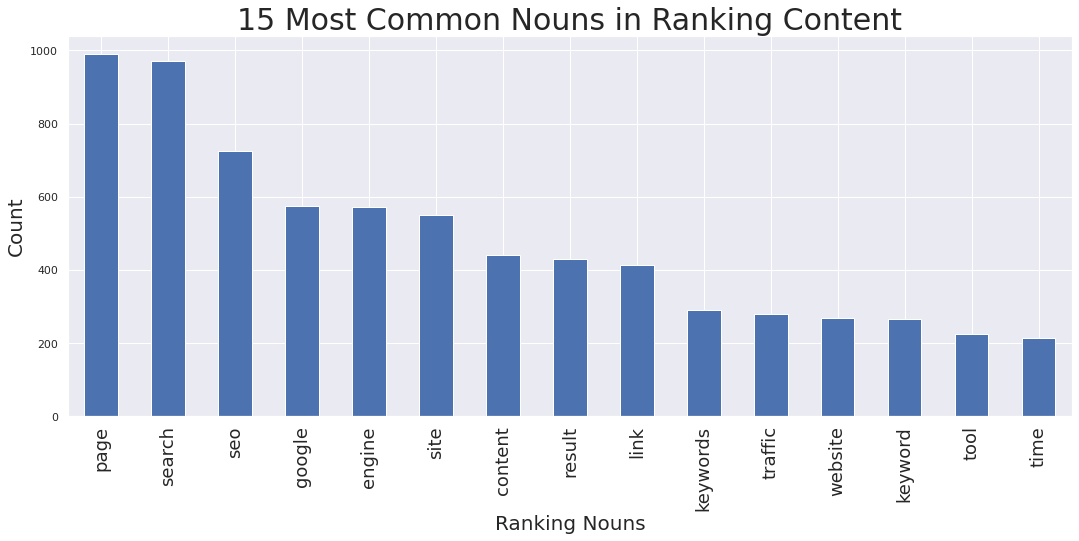

In [ ]:
sns.set_theme()
fig,ax = plt.subplots()
ax=pos_df['Noun'].sort_values(ascending=False).head(15).plot(kind='bar',figsize=(18,7))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common Nouns in Ranking Content',fontsize = 30)
ax.set_ylabel('Count',fontsize = 20)
ax.set_xlabel('Ranking Nouns',fontsize = 20)
fig.show()

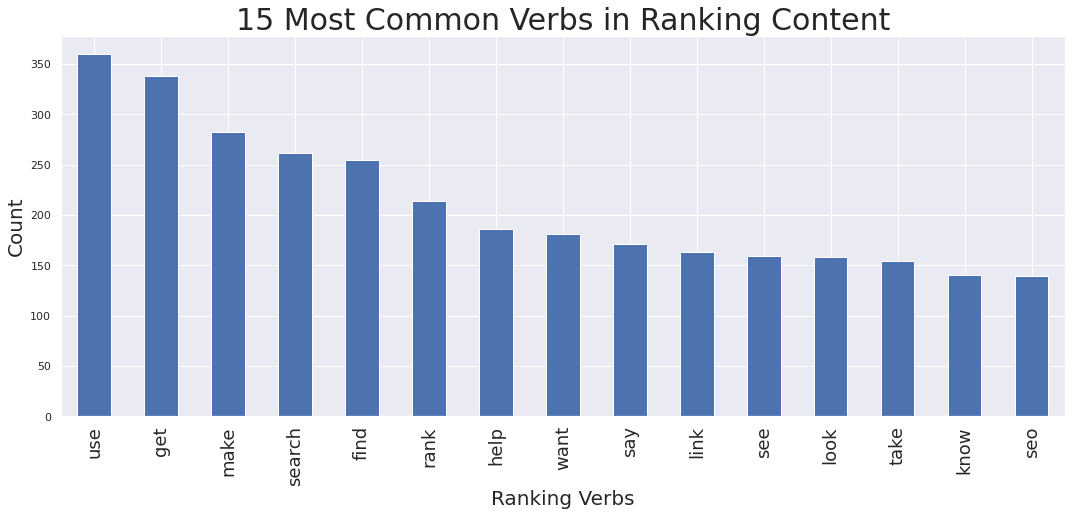

In [ ]:
sns.set_theme()
fig,ax = plt.subplots()
ax=pos_df['Verb'].sort_values(ascending=False).head(15).plot(kind='bar',figsize=(18,7))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common Verbs in Ranking Content',fontsize = 30)
ax.set_ylabel('Count',fontsize = 20)
ax.set_xlabel('Ranking Verbs',fontsize = 20)
fig.show()

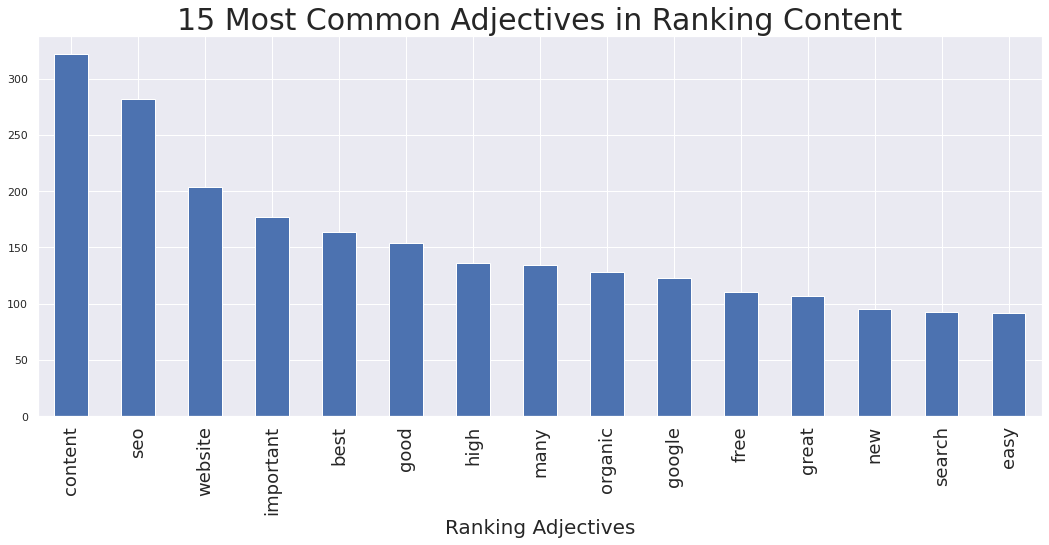

In [ ]:
sns.set_theme()
fig,ax = plt.subplots()
ax=pos_df['Adjective'].sort_values(ascending=False).head(15).plot(kind='bar',figsize=(18,7))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common Adjectives in Ranking Content',fontsize = 30)
ax.set_xlabel('Count',fontsize = 20)
ax.set_xlabel('Ranking Adjectives',fontsize = 20)
fig.show()

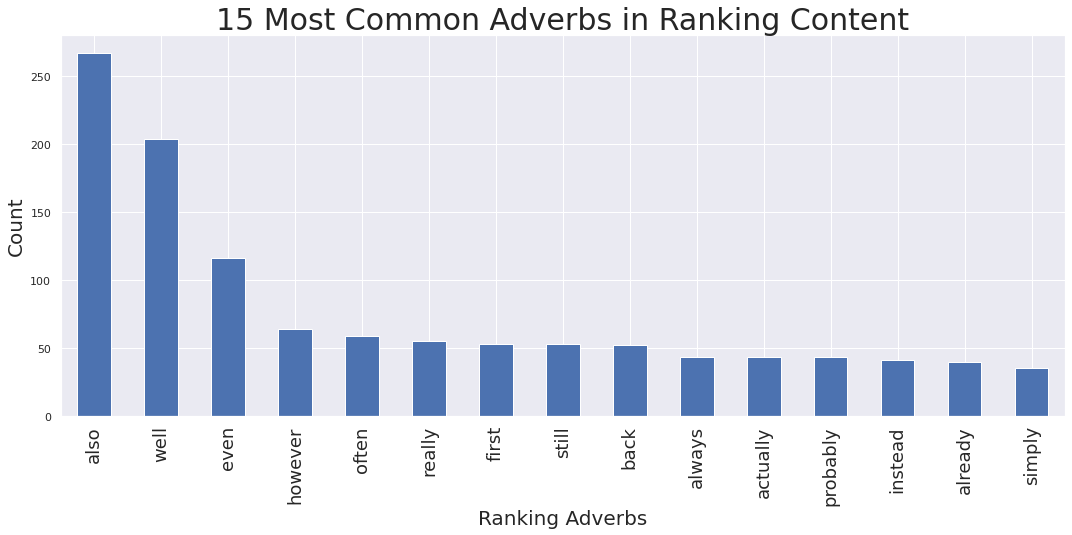

In [ ]:
sns.set_theme()
fig,ax = plt.subplots()
ax=pos_df['Adverb'].sort_values(ascending=False).head(15).plot(kind='bar',figsize=(18,7))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common Adverbs in Ranking Content',fontsize = 30)
ax.set_ylabel('Count',fontsize = 20)
ax.set_xlabel('Ranking Adverbs',fontsize = 20)
fig.show()

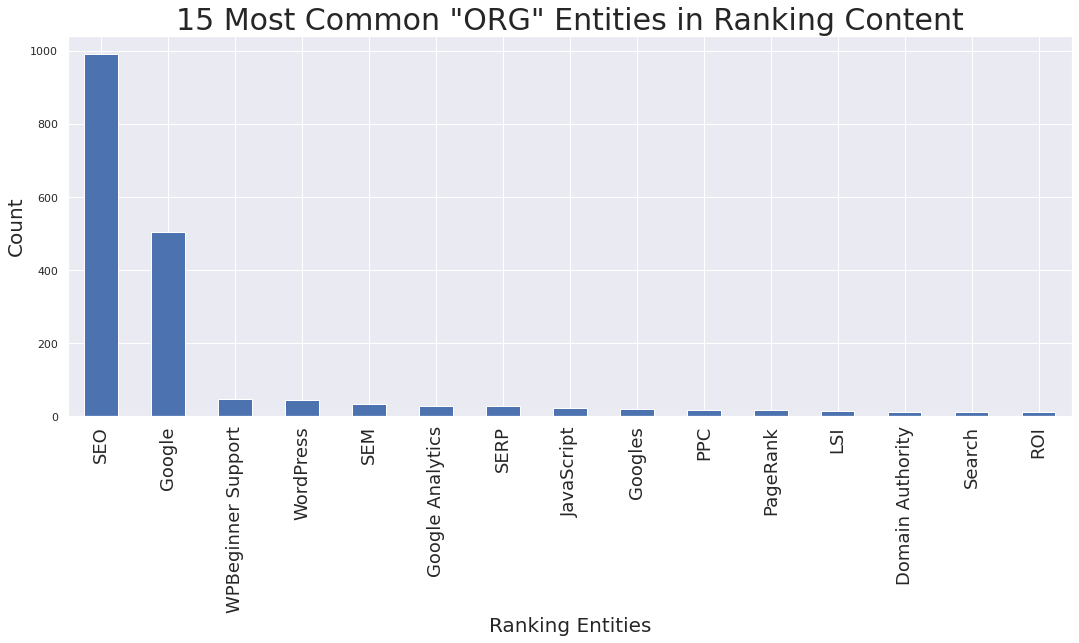

In [ ]:
sns.set_theme()
fig,ax = plt.subplots()
ax=ent_df['ORG'].sort_values(ascending=False).head(15).plot(kind='bar',figsize=(18,7))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common "ORG" Entities in Ranking Content',fontsize = 30)
ax.set_xlabel('Ranking Entities',fontsize = 20)
ax.set_ylabel('Count',fontsize = 20)
fig.show()

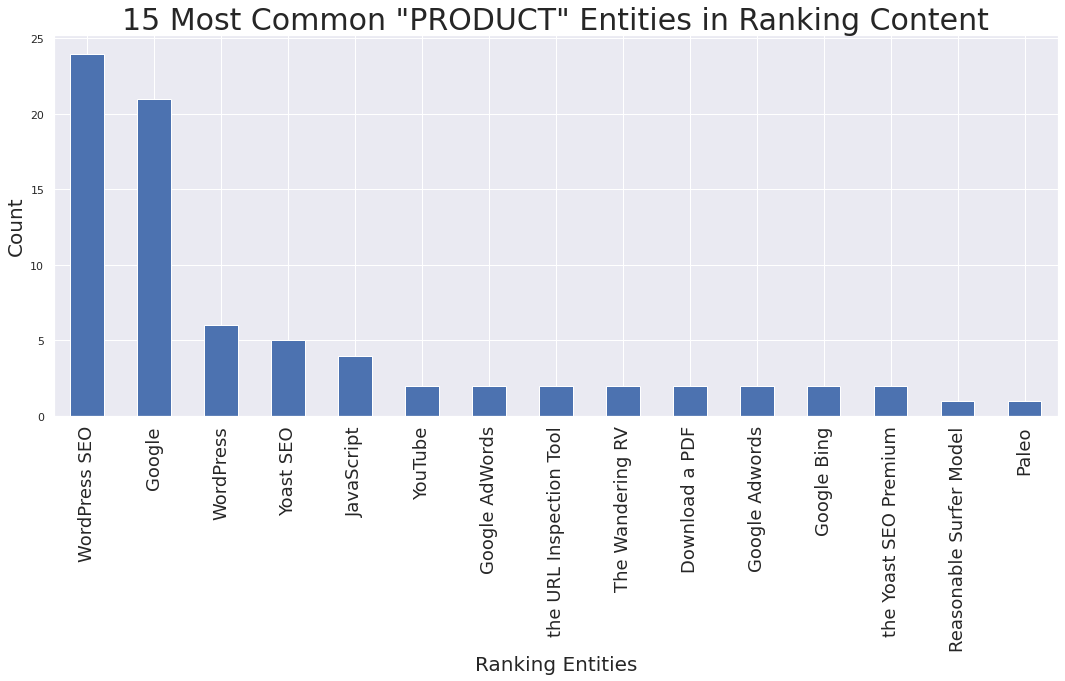

In [ ]:
sns.set_theme()
fig,ax = plt.subplots()
ax=ent_df['PRODUCT'].sort_values(ascending=False).head(15).plot(kind='bar',figsize=(18,7))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common "PRODUCT" Entities in Ranking Content',fontsize = 30)
ax.set_ylabel('Count',fontsize = 20)
ax.set_xlabel('Ranking Entities',fontsize = 20)
fig.show()

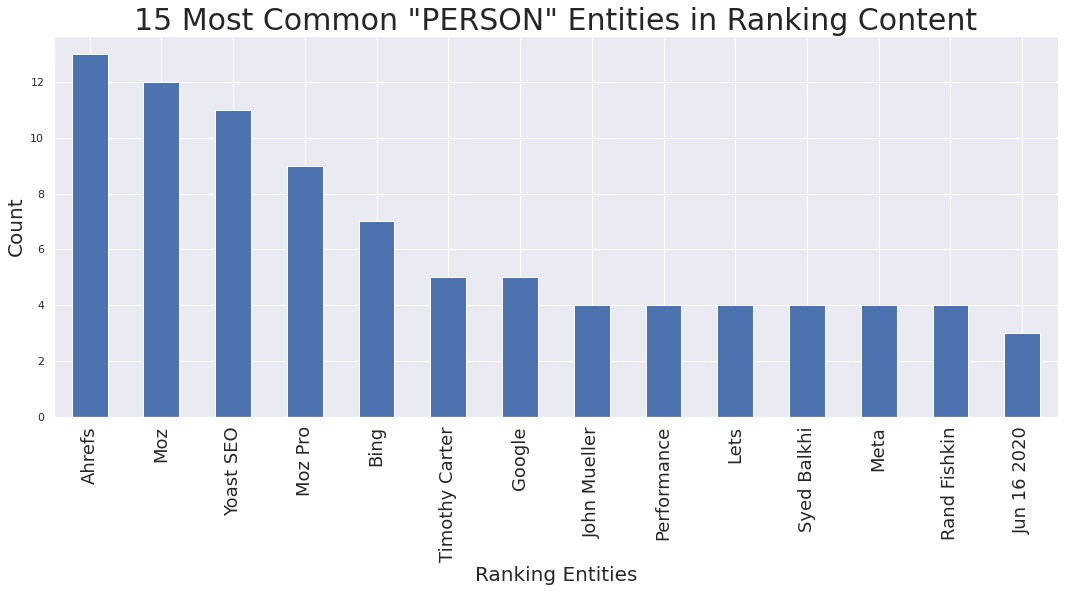

In [ ]:
sns.set_theme()
fig,ax = plt.subplots()
ax=ent_df['PERSON'].sort_values(ascending=False).head(14).plot(kind='bar',figsize=(18,7))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common "PERSON" Entities in Ranking Content',fontsize = 30)
ax.set_ylabel('Count',fontsize = 20)
ax.set_xlabel('Ranking Entities',fontsize = 20)
plt.show()

In [ ]:
print(ent_df['PERSON'].sort_values(ascending=False).head(15))

Ahrefs            13.0
Moz               12.0
Yoast SEO         11.0
Moz Pro            9.0
Bing               7.0
Timothy Carter     5.0
Google             5.0
John Mueller       4.0
Performance        4.0
Lets               4.0
Syed Balkhi        4.0
Meta               4.0
Rand Fishkin       4.0
Jun 16 2020        3.0
Meta Tag           3.0
Name: PERSON, dtype: float64


In [ ]:
#uncomment this to see money entities

'''
sns.set_theme()
fig,ax = plt.subplots()
ax=ent_df['MONEY'].sort_values(ascending=False).head(15).plot(kind='bar',figsize=(22,9))
plt.xticks(fontsize=18, rotation=90)
ax.set_title('15 Most Common "MONEY" Entities in Ranking Content',fontsize = 30)
ax.set_xlabel('Count',fontsize = 20)
ax.set_ylabel('Ranking Entities',fontsize = 20)
fig.show()
'''

'\nsns.set_theme()\nfig,ax = plt.subplots()\nax=ent_df[\'MONEY\'].sort_values(ascending=False).head(15).plot(kind=\'bar\',figsize=(22,9))\nplt.xticks(fontsize=18, rotation=90)\nax.set_title(\'15 Most Common "MONEY" Entities in Ranking Content\',fontsize = 30)\nax.set_xlabel(\'Count\',fontsize = 20)\nax.set_ylabel(\'Ranking Entities\',fontsize = 20)\nfig.show()\n'

In [ ]:
#https://networkx.org/documentation/networkx-1.10/reference/introduction.html
#use betweenness centrality to see which words are more important than others and rank them in descending order
#Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. 
#It is often used to find nodes that serve as a bridge from one part of a graph to another.
#https://www.youtube.com/watch?v=ptqt2zr9ZRE&ab_channel=AnuradhaBhatia

noun_phrases = [[token for token, pos in item if re.match(r'NN*|JJ*', pos)] for item in content_df.Content]
edges = [edge for phrase in noun_phrases for edge in it.combinations(phrase, 2)]

G = nx.Graph(edges)
index = nx.betweenness_centrality(G)
for component in list(nx.connected_components(G)):
    if len(component)<5:
        for node in component:
            G.remove_node(node)

sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)

resonance_df = pd.DataFrame(sorted_index, columns=['Word', 'Centrality'])



/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  alpha=alpha,
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:789: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  arrow_colors = mpl.colors.colorConverter.to_rgba_array(edge_color, alpha)


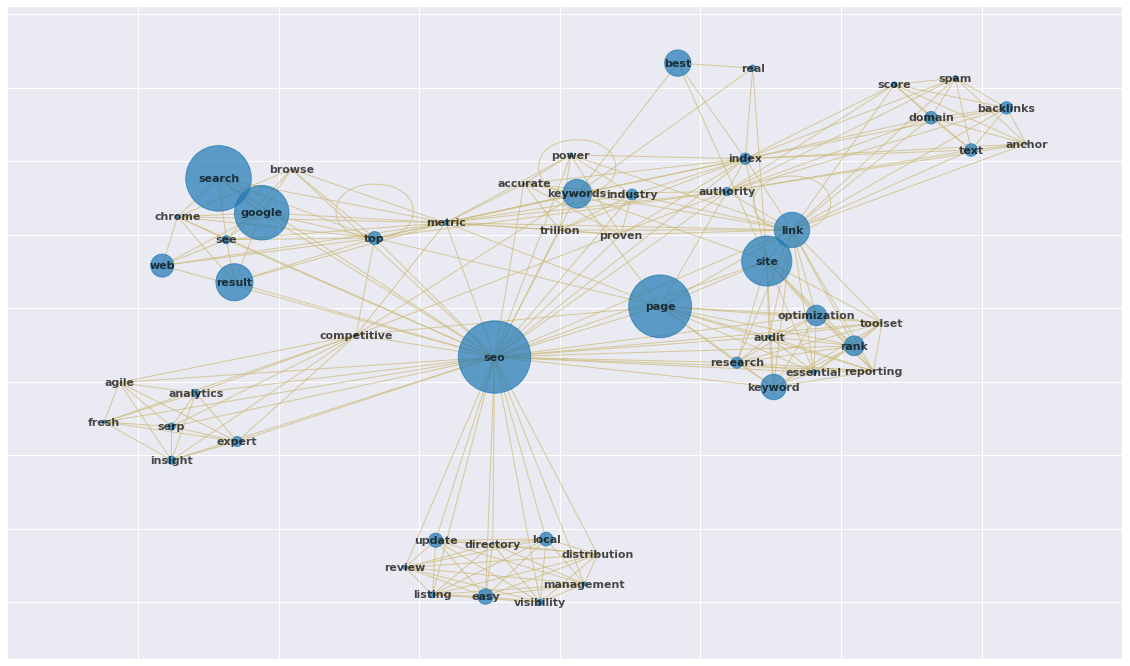

In [ ]:
#use this cell to visualize the graph. use a number where the graph does not gets cluttered and can actually provide insight
#200-400 is usually a sweet spot
#you might need to run it for a few times to get the best view of the graph

##########

number_of_data_points_to_show_in_graph=302

##########


G2 = nx.Graph(edges[:number_of_data_points_to_show_in_graph])
plt.rc('figure', figsize=(20, 12))
G.remove_nodes_from([unnecessary_nodes for unnecessary_nodes in index if index[unnecessary_nodes] == 0])
G.remove_nodes_from([node for node,degree in dict(G2.degree()).items() if degree < 2])
node_size = [index[n]*70000 for n in G2]
nx.draw_networkx(G2, nx.spring_layout(G2), node_size=node_size, edge_color='Y', alpha=.7, font_color='Black', font_size='11', font_weight='bold')

In [ ]:
#normalizing the centrality values
#this makes the values between 1 and 0.B

resonance_df.sort_values('Centrality', ascending=False,inplace=True)
max_resonance = max(list(resonance_df['Centrality']))

def normalize(num):
  return num/max_resonance

resonance_df['Centrality'] = resonance_df['Centrality'].apply(normalize)
resonance_df.head(15)


,Word,Centrality
0,seo,1.000000
1,search,0.820303
2,page,0.754551
3,content,0.634620
4,google,0.566673
5,site,0.480293
6,website,0.436181
7,engine,0.385038
8,new,0.306842
9,result,0.262551


<Figure size 1440x864 with 0 Axes>

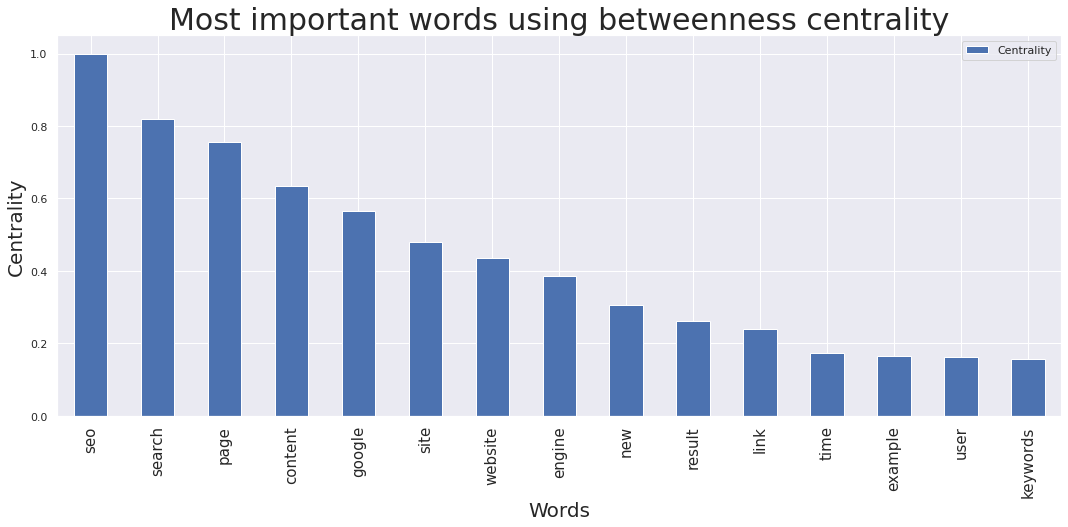

In [ ]:
words = list(resonance_df['Word'])
resonance = list(resonance_df['Centrality'])

data = {'Words':words[:15]
       ,'Centrality':resonance[:15]}
res=pd.DataFrame(data=data)
plt.clf()

sns.set_theme()
#plt.bar(resonance[:15],range(0,1))
#df.plot(x="X", y=["A", "B", "C"], kind="bar")
#plt.figure(figsize=(22,9))
res.plot(x='Words',y='Centrality',kind='bar',figsize=(18,7))
plt.xticks(fontsize = 15, rotation=90)
plt.title('Most important words using betweenness centrality',fontsize = 30)
plt.xlabel('Words',fontsize = 20)
plt.ylabel('Centrality',fontsize = 20)
plt.show()

In [ ]:
with pd.ExcelWriter('Output.xlsx') as writer:
  pos_df.to_excel(writer,sheet_name='Parts of Speech')
  ent_df.to_excel(writer, sheet_name='Entities')
  content_trend_3_df.to_excel(writer,sheet_name='3 word phrases',index=False)
  content_trend_4_df.to_excel(writer,sheet_name='4 word phrases',index=False)
  content_trend_5_df.to_excel(writer,sheet_name='5 word phrases',index=False)
  content_trend_6_df.to_excel(writer,sheet_name='6 word phrases',index=False)
  title_trend_df.to_excel(writer,sheet_name='Common phrases in titles',index=False)
  resonance_df.to_excel(writer,sheet_name='Word Centrality',index=False)